In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html {font-family: 'Open Sans'; font-size: 20px; line-height: 150%;}</style>"))

# Introduction to Face Detection and Face Recognition
Yossi Cohen  
Data science workshop project  
Jun 2019
<img src='images/face-recognition.jpg' title='face recognition' width='25%' height='25%' />

# Table of contents
- [Introduction](#Introduction)
- [Outline](#Outline)
- [Chapter 1: CNN Background](#Chapter-1)
- [Chapter 2: Face Detection](#Chapter-2)
  - [Haar (Viola-Jones)](#Haar-\(Viola-Jones\))
  - [LBP](#LBP)
  - [HOG](#HOG)
  - [DLIB CNN](#DLIB-CNN)
  - [OpenCV DNN](#OpenCV-DNN)
  - [MTCNN](#MTCNN)
- [Alignment (pose detection)](#Alignment-\(pose-detection\))
- [Feature extraction](#Feature-extraction)
- [Chapter 3: Face Verification and Identification](#Chapter-3)
  - [One shot learning](#One-shot-learning)
  - [Siamese networks](#Siamese-networks)
  - [Contrastive Loss](#Contrastive-Loss)
  - [Triplet Loss](#Triplet-Loss)
- [Chapter 4: Facial expression analysis](#Chapter-4)
- [Chapter 5: Playground framework for face detection and face recognition](#Chapter-5)
- [Chapter 6: Concluding remarks](#Chapter-6)
- [References](#References)

# Introduction

In the Computer Vision field, one of the most studied topics is Face Detection.  
Given an arbitrary image or video frame, the goal of face detection is to determine whether there are
any faces in the image and, if present, return the bounfing box of each face.  Face detection is easily done by humans, but it is still a challenging for Computers.  The high degree of variability of the human face makes it very difficult to detect, mainly in complex environments. Most of the existing complexity is due to occlusion (i.e. face is partially visible), illumination conditions (e.g. darker and lighter environments), background clutter (e.g. background and object in scene are too similar in color intensities), and so on.  Face detection is an important first step in many applications such as video surveillance, face authentication, organization of digital photo-albums, and face recognition.


Face recognition identify faces in images or video frames.  In a nutshell, a face recognition system extracts features of faces from an input image and compares them to the features of labeled faces. Comparison is based on a feature similarity metric and the label of the most similar labeled face fetures is used to label the input image.  If the similarity value is below a certain threshold the input image is labeled as unknown. Comparing two face images to determine if they show the same person is known as face verification (one to one comparision). Comparing a face to all known faces is known as face identification (one to many).

The whole process involves the following steps in order:
- **Detection** - Face detection results in bounding box for each detected face.

- **Alignment** - Crop & Align faces such that each face nose and eyes are centered.

- **Feature extraction** - Extract face feature vectors (n-dimentional embeddings) from the aligned input images.  
  (in embedding space, the euclidean distance directly corresponds to a measure of face similarity.)

- **Identification** Identify an extracted embedding vector by comparing it to the labeled embedding vectors.  
  (this can be achieved by using e.g., a databse of labeled embedding vectors or by utilizing SVM/KNN classifiers to predict the input embedding label)

<img src='images/face-recognition-pipeline.png' title='Face Recognition pipeline' />
<center>Face Recognition pipeline</center>

In the following sections, I'll explain and demonstrate several face detection and face recognition methods. Each has a different approach to extract the image information and perform the matching with the input image. These methods also differ by their accuracy, performance and resource consumption. Some may run in realtime even on low resource devices such as cell phones and embedded devices (e.g: *Raspberry PI*). Those methods may be used for frontal face detection (e.g. to unlock a phone or verify a passport image).  More advanced methods may require the use of GPUs and may be used for applications like intelligence and surveillance. Advanced methods are usually more accurate, and more robust to alignment, illumination variation, low resolution and occlusion.


## Outline

This Introduction is orgenized as follows:

**Chapter 1** (<font style='background-color: yellow'>TODO</font>) reviews and explains convolutional neural networks (CNNs).  
I detail how CNNs work, their different architectures and implementations.  
I also explain how they are applied in classification, detection, alignment, and face recognition.

**Chapter 2** focuses on face detection.   
It reviews, explains and demonstrates several classic and more recent face detection methods.

**Chapter 3** focuses on face recognition.   
It introduces the methods used in each step of the face recognition process with examples.

**Chapter 4** will present some additional applications related to visual face processing such as:  
Age detection, Gender detection, Ethnicity detection and Facial expression analysis.

**Chapter 5** details the implementaion of a playground face recognition library.  
The library demonstrats the use of the methods described above and may be used for comparing the different methods.

**Chapter 6** (<font style='background-color: yellow'>TODO</font>) has my concluding remarks.  
I detail and explain directions for future work.

# Chapter 1
<font style='background-color: yellow'>TODO</font>
[ref](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/)

## CNN Background

This chapter, presents the background needed for understanding deep learning approaches to face detection and face recognition.  
It is orgenized as follows:  
- Introduction to convolutional neural networks and its main components.  
- Present the application of convolutional neural networks for classification and object localization.  
- Convolutional neural networks for metric learning.

### 1.1 - Introduction

In the context of computer vision, deep learning is described as multiple layers of processing units. Layers form a hierarchy of feature extraction, transforming the representation of the input n from low-level to a higher and more abstract level.  

The first layers response to low-level features in the input and higher (deeper) layers response to high-level input features.   If the input is an image, for example, the first layer may be able to detect edges. The next layer might detect more complex forms by focusing on specific portions of the image, etc. Deeper layers learn even more complex features of the image (possibly combination of former features - e.g: a face is composed of two eyes, a nose, ears, a mouth, atc.).  A key observation is that the features are learned from data (annotated data in the case of supervised learning).  

<table>
    <tr>
        <td><img src='images/cnn-edges.png' title='cnn edges' width='50%' /></td>
        <td><img src='images/cnn-face-parts.png' title='cnn face parts' /></td>
        <td><img src='images/cnn-face-whole.png' title='cnn whole faces' /></td>
    </tr>
</table>
<center>Figure 1.1 (<a href='http://robotics.stanford.edu/~ang/papers/icml09-ConvolutionalDeepBeliefNetworks.pdf'>source</a>)</center>

Much of the success of deep learning is due to the success of convolutional neural networks (CNNs) in image classification (when the [ImageNet challange](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge) was won by the *AlexNet* designed by Alex Krizhevsky, and published with Ilya Sutskever and Krizhevsky's PhD advisor Geoffrey Hinton).

### 1.2 - CNN architecture
ConvNets or CNNs — are feed-forward neural networks that can learn features invariant to translation, rotation, and shifting. They use *convolutions* instead of fully connected layers in at least one of their layers.  
A typical CNN has usually three types of layers: convolution layers, pooling (Subsampling) layers, and fully-connected layers. These layers are stacked on top of each other to form the Convolutional Neural Network.  

**Convolution layers:**

**Convolution** is a mathematical operation that convolves a filter (aka kernel) over images.  The filter slides over the image, computing dot products between the kernel and the input matrix region under the kernel. The output of a convolution operation is called *feature map*, and feature maps can also be used as input to a convolution.

<img src='images/convolution.gif' title='convolution animation' width='70%' />
<center>Figure 1.2.1 (<a href='http://cs231n.github.io/convolutional-networks/'>source</a>)</center>

Figure 1.2.2 shows an example of a convolution operation with a given kernel using an image as input. 
On the left can see the input image and on the right side the resulting feature map after applying the kernel. 
In this scenario, the resulting feature map represents the edges of the input image.

<img src='images/feature-map.jpeg' title='feature map' />
<center>Figure 1.2.2</center>

After convolving with the kernel, a **bias term** is added to the resulted feature-map and an activation function (non-linearity) is applied to their sum.  

An **activation function** takes a single number and performs a specific mathematical operation over it. Activation function introduce non-linearity in the neural network, which means that the output cannot be reproduced from a linear combination of the inputs. Traditional neural networks make use of the **Sigmoid** activation function (equation 2.2). It maps the given number $x$ into a range within $[0,1]$. There are other activations functions such as the **Tanh (Hyperbolic Tangent)** and **ReLU (Rectified Linear Unit)**.

<font style='background-color: yellow'>TODO</font>

**Pooling layers:**
<font style='background-color: yellow'>TODO</font>

**Fully-Connected- layers:**
<font style='background-color: yellow'>TODO</font>


CNNs act as feature extractors, which means that the convolutional layers extract features from the data.  
The fully-connected layers at the end of the CNN can be seen as a regular neural network. 

### 1.3 - Classification

Classification is the task of assigning objects to one of several categories.  
It maps a given input instance $x$ to a class label $y$. For instance, in character recognition, where a classification determines which number is present in the input image.  

Classification algorithms are trained with examples and learn a model. The learned model is then used to classify unseen examples.  In character recognition, the training set is comprised of $(X, y)$ pairs, where $X$'s are image pixel’s intensities and $y$ indicates the label $(0..9)$.  

In the training phase, a **loss function** is used to compute the classification error.  
Methods such as **SGD (Stocastic Gradient Decsent)** and **backpropagation** are than used to adjust the model weights as training samples pass though the network (the loss is computed at the end of each forward pass and the error is backpropagated in the backword pass. The weights are than adjusted in an oposite direction of the loss gradient to reach a minima of the loss function).  

### 1.4 - Localization

Object localization (or detection) is the task of detecting objects of known classes in images.  It searches for an object within an image and outputs its location (usually as a bounding box) and the object class.  

Object detection is considered harder than classification problems due to its complexity. The localization of objects depends on numerous candidate object locations that need to be refined in order to achieve a precise localization.  

Object detection differs from classification in the evaluation methodology as well. In classification, we compute whether the correct label is assigned to a given instance. In object detection we need to evaluate whether a predicted bounding box is correct with respect to the ground truth bounding box. A bounding box is an area defined by $(x, y, w, h)$, where x and y are usually the (top, left) coordinates of the bounding box, $w$ is the width and $h$ is the height of the box.  

A measure called **Intersection Over Union (IoU)** is used to calculate the amount of overlap between two bounding boxes. The IoU between two bounding boxes A and B is given by the intersection between A and B divided by their union. The result is in range $[0,1]$, where $1$ represents $100%$ overlap and $0$ represents no overlap whatsoever.

<p>
<font size=5>
$$\large{IoU(A,B)} = \frac{A ∩ B}{A ∪ B} \tag{1.4.1}$$
</font>

Figure 1.4.1 shows an example of different bounding box predictions and the impact on the IoU value. 
The larger the IoU value, the more similar are the two bounding boxes.

<img src='images/IoU.png' title='IoU (Intersection over Union)' />
<center>Figure 1.4.1 - green rectangles are ground truth, red rectangles are predictions</center>

IoU is also used in several implementations of face detection when multiple detections of the same object overlap.  Using a method called **Non-Maximum Suppression (NMS)** which reduces the number of overlapping bounding boxes for same face in the image.

<img src='images/NMS.png' title='Non-Maximum Suppression (NMS)' width='80%' />
<center>Figure 1.4.2 - Non-Maximum Suppression</center>


### 1.5 - Metric learning
<font style='background-color: yellow'>TODO</font>

# Chapter 2
This chapter will present some of the classic and more recent methods of face detection.  
It is organized as follows. I first give a brief introduction of face detection.  Next, I present some face detection classic approaches, based on hand-crafted features. Then, I present deep learning approaches.

## Face Detection
Face detection is a technique used for locating human faces in digital images. Face detection is different from Face recognition, it detects merely the presence of faces in an image while face recognition involves identifying whose face it is.

The topic of face detection is studied for a long time, however, implementations were not able to perform well under the unconstrained setting. Unconstrained face detection — also known as *face detection in-the-wild* — refers to recognizing faces in images in real world conditions. For instance, variations in pose, lighting, expression, race, ethnicity, age, gender, clothing, hairstyles etc.

The Viola-Jones face detector [1] was one of the major breakthroughs in face detection. Most of the current digital cameras still use the Viola-Jones face detector. After that seminal implementation, subsequent attempts were focused on beating thses results in both accuracy and speed. Improvements like robust feature extractors such as Histograms of Oriented Gradients (HOG) [2]; more powerful classifiers such as Support Vector Machines (SVM) [3], and more recently, Deep Learning approaches [6,7,8]; large-scale unconstrained face recognition datasets such as Labeled Faces in the Wild (LFW) [13] and FDDB [14]; libraries and frameworks, such as dlib and OpenCV.

There are many different facial detection models currently in use.  Lets go over them briefly.  

**Deep Neural Networks (DNNs)**: DNNs are trained to detect faces in many different orientations. One popular method for DNN based facial detection is the single-shot-multibox detector. DNNs are accurate and versatile.  

**Convolutional Neural Networks (CNNs)**: CNN is designed to assign importance to different parts of an image. It is robust but quite slow on a CPU.  

**Haar Cascade Classifiers**: Haar cascades are trained using a data set with a large amount of labelled positive and negative example images. The major drawback of Haar cascade classifiers is that they can only identify faces front-on. They aren’t widely used anymore as neural networks are more versatile.  

**Histogram of Oriented Gradients (HOG)**: A HOG is a facial detection method that divides an input image into grid of cells with gradient orientations. Then it feeds the result into a support vector machine.  HOG detection is fast and lightweight but fails for some unusual facial angles.  


<img src='images/wider-faces.png' title='Examples of images from the WIDER FACE dataset' />
<center>
    <font>
        Figure 2.1 - Examples of images from the WIDER FACE dataset
        <br><a href=http://shuoyang1213.me/WIDERFACE/>source</href>
    </font>
</center>

The large amount of images in face detection datasets allows deep learning algorithms to learn representative features for detecting faces and outperform Viola-Jones and other previous implementations. In the following sections, we'll start exploring some face detectors based on hand-crafted and continue to deep learning approaches.


## Haar (Viola-Jones)

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, [“Rapid Object Detection using a Boosted Cascade of Simple Features”](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) in 2001.

The Haar face detection is very efficient and can be used on low resource devices (e.g., cell phones, Raspberrypi).

Viola-Jones work is distinguished by three key contributions:  
- The first is the introduction of a new image representation called the [“Integral Image”](#Integral-Image) that allows for very fast feature evaluation.  
- The second is a [learning algorithm, based on AdaBoost](#Adaboost), which selects a small number of critical visual features from a larger set and yields extremely efficient classifiers.  
- The third contribution is a method for combining increasingly more complex classifiers in a [“cascade”](#Cascading) which allows background regions of the image to be quickly discarded while spending more computation on promising object-like regions.  

**HAAR fetures explained**  

Haar features are like convolutional kernels which are used to detect the presence of that feature in the given image.  

<img src='images/haar-like-features.png' />

Each feature window is placed on the picture to calculate a single feature value.  
The value calculated by subtracting the sum of pixels under the white rectangle from the pixels under the black rectangle.  

All possible sizes of each window are placed on all possible locations of each image to calculate plenty of features.  

For example, feature (1.a): 1x1 pixels is moved all over the image (top-left to bottom-down) to calculate its feature values.  
The same feature (1.a) is then resized to: 1x4 pixes (2 wight pixels, 2 black pixels in a row) and the feature values calculation process repeates again.  
The process repeates for each feature, for each possible feature scale.

<img src='images/haar-like-features-placed-on-top-of-image.png' />

For example, in above image, we are extracting two features. The first one focuses on the property that the region of the eyes is often darker than the area of the nose and cheeks. The second feature relies on the property that the eyes are darker than the bridge of the nose.

Among all these features calculated, most of them are irrelevant.  
For example, when used on the cheek, the windows become irrelevant because none of these areas are darker or lighter than other regions on the cheeks.

So irrelevant features are discarded and we keep only those relevant with a technique called Adaboost.  
**AdaBoost** is a training process which selects only those features known to improve the classification (face/non-face) accuracy of our classifier.

**Integral Image**  

The integral image can be computed from an image using few operations per pixel.
Once computed, any one of these Harr-like features can be computed at any scale or location in constant time.

Viola-Jones algorithm uses 24x24 pixels as a base window size to start evaluating these features in any given image.

If we consider all possible parameters of the haar features like position, scale and type, we end up calculating about 160,000+ features in this window

In order to solve this problem, Viola-Jones came up with this idea:  
- In an integral image, the value at pixel (x,y) is the sum of pixels **above and to the left** of (x,y)

<img src='images/haar-integral-image.png' />

- Integral image allows for the calculation of sum of all pixels inside any given rectangle using only 4 values at the corners of the rectangle.  

- To calculate the sum of all pixels in area D:  
we add the sums of the areas of the top-left/right-bottom diagonal from the sums of the areas of the other diagonal (bottom-left/top-right)

<img src='images/haar-integral-image-2.png' />

This trick allows to cut off many many addition operations!

**Adaboost**  

As stated previously, the can be approximately 160,000+ feature values within a detector at 24x24 base resolution which need to be calculated.  but only small part of them will be usefull.  

For example in the picture below, only the left feature is relevant.  
The right feature over the lip will not ield high values because the image values at the lip do not change.

<img src='images/haar-discard-irrelevant-features.png' />

Adaboost is used to discarded such irrelevant features.  
Adaboost is a ML algorithm which helps finding only the best features among all of these 160,000+ features.  
After these features are found, a weighted combination of them is used to determine if an image contains a face or not.

Each of the selected features are considered to be "Okay" to be included if they can perform atleast better then random guessing (detects more of half of the cases).

These features are also called "weak classifiers". Adaboost constructs a strong classifier $F(x)$ as a linear combination of these "weak classifiers" $f_k(x)$.
$F(x) = \alpha_1f_1(x) + \alpha_2f_2(x) + ... + \alpha_kf_k(x)$ for some $k$.  

The workings of [Adaboost](https://en.wikipedia.org/wiki/AdaBoost) is beyond the scop of this paper.

**Cascading**  

- The basic principle of Viola-Jones algorithm is to scan the detector many time through the same image - each time with a new size.
- Even if an image contain one or more faces, an excessive amount of the evaluated sub-windows would still be negative (non-faces)
- So the algorithm should concetrate on discarding non-faces quickly and spend more time on probable face regions.


### Example: Haar face detection using opencv
The code below will load the following image and run Haar face detector.  
<img src='images/indian_faces.jpeg' title='indian faces' />

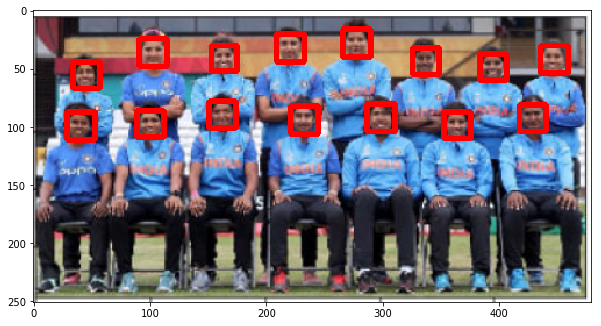

In [490]:
import cv2
import imutils
import matplotlib.pyplot as plt

def haar_detection_image():

    # load classsifier
    cascade = cv2.CascadeClassifier('models/detection/haarcascade_frontalface_alt.xml')

    # read image
    image = cv2.imread('images/indian_faces.jpeg')

    # convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resize image to help detection
    # (playing with the image width will yield different performance)
    image = imutils.resize(image, width=480)

    # convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the frame.
    faces = cascade.detectMultiScale(
        gray,               # the input image.
        scaleFactor=1.1,    # specify how much the image size is reduced at each image scale. 
        minNeighbors=5,     # specify how many neighbors each candidate rectangle should have, b
                            # to retain it. A higher number gives lower false positives.
        minSize=(10, 10)    # the minimum rectangle size to be considered a face.
    )

    # draw rectangles around the faces.
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

    # display the image
    plt.figure(figsize = (10, 10))
    _ = plt.imshow(image)

haar_detection_image()


### Example: Haar face detection using opencv (realtime)
The code below will play a video file and run Haar face detector in realtime.  
As you can see, not all faces are detected and occationally we get some false positives!

press 'ESC' to quit



In [3]:
import cv2
import numpy as np

def haar_detection_video():
    # load classifier
    cascade = cv2.CascadeClassifier('models/detection/haarcascade_frontalface_alt.xml')

    cap = cv2.VideoCapture('src/examples/face_detection/videos/vid.mp4')

    width = int(cap.get(3))
    height = int(cap.get(4))

    # save output video ?
    SAVE_VIDEO = True
    if SAVE_VIDEO:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter('videos/output.mp4', fourcc, 30, (width, height))

    while(cap.isOpened()):
        # read frame
        ret, frame = cap.read()
        if not ret:
            break

        # convert image to graysacle
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # detect faces in the frame.
        faces = cascade.detectMultiScale(
            gray,               # the input image.
            scaleFactor=1.3,    # specify how much the image size is reduced at each image scale. 
            minNeighbors=3,     # specify how many neighbors each candidate rectangle should have, b
                                # to retain it. A higher number gives lower false positives.
            minSize=(10, 10))   # the minimum rectangle size to be considered a face.

        # draw rectangles around the faces.
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)

        # write the output frame to file
        if SAVE_VIDEO:
            out.write(frame)

        # display the frame
        cv2.imshow('video', frame)

        # press 'q' or ESC' to quit
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q") or 27 == key:
            break

    if SAVE_VIDEO:
        out.release()
    cap.release()
    cv2.destroyAllWindows()

if False:
    haar_detection_video()

<img src='images/haar_detection_video.gif' width='50%' />

### LBP

<font style='background-color: yellow'>TODO</font>
see: [opencv: local-binary-patterns-histograms](https://docs.opencv.org/2.4/modules/contrib/doc/facerec/facerec_tutorial.html#local-binary-patterns-histograms)

#### Introduction
Local Binary Pattern [(LBP)](http://www.scholarpedia.org/article/Local_Binary_Patterns) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.

It was first described in 1994 (LBP) and has since been found to be a powerful feature for texture classification. It has further been determined that when LBP is combined with histograms of oriented gradients (HOG) descriptor, it improves the detection performance considerably on some datasets.

Using the LBP combined with histograms we can represent the face images with a simple data vector.

#### Steps of the algorithm

**1. Parameters**: the LBPH uses 4 parameters:
  - **Radius**: the radius is used to build the circular local binary pattern and represents the radius around the central pixel. It is usually set to 1.
  - **Neighbors**: the number of sample points to build the circular local binary pattern. the more sample points, the higher the computational cost. It is usually set to 8.
  - **Grid X**: the number of cells in the horizontal direction. The more cells, the finer the grid, the higher the dimensionality of the resulting feature vector. It is usually set to 8.
  - **Grid Y**: the number of cells in the vertical direction. The more cells, the finer the grid, the higher the dimensionality of the resulting feature vector. It is usually set to 8.

**2. Training the Algorithm**: For training, we need to use a dataset with facial images of the people we want to recognize.  Each image should be associated with an ID (a number or the name of the person). Images of the same person must have the same ID.

**3. Applying the LBP operation**: LBPH creates an intermediate image that describes the original image in a better way, by highlighting the facial characteristics. To do so, the algorithm uses a sliding window, based on the parameters radius and neighbors.  
The image below shows this procedure:
<img src='images/LBPH-01.png' title='LBP operation' />
**Step by step explenation of the LBP operation:**
- We have a facial image in grayscale.
- We take part of this image as a window of 3x3 pixels.
- It can also be represented as a 3x3 matrix containing the intensity of each pixel (0~255).
- Then, we take the central value of the matrix as a threshold.
- This value will be used to define the new values from the 8 neighbors.
- For each neighbor of the central value (threshold), we set a new binary value. We set 1 for values equal or higher than the threshold and 0 for values lower than the threshold.
- Now, the matrix will contain only binary values (ignoring the central value). We need to concatenate each binary value from each position from the matrix line by line into a new binary value (e.g. 10001101). Note: There are other approaches to concatenate the binary values (e.g. clockwise direction), but the final result will be the same.
- Then, we convert this binary value to a decimal value and set it to the central value of the matrix, which is actually a pixel from the original image.
- At the end of this procedure we have a new image which represents better the characteristics of the original image.

**Note:** The LBP procedure was expanded to use a different number of radius and neighbors, it is called *Circular LBP*.  
<img src='images/LBPH-02.png' title='Circular LBP' />

It can be done by using bilinear interpolation. If some data point is between the pixels, it uses the values from the 4 nearest pixels (2x2) to estimate the value of the new data point.

**4. Extracting the Histograms**: Using the image generated in the last step, we can use the *Grid X* and *Grid Y* parameters to divide the image into multiple grids, as can be seen in the following image:
<img src='images/LBPH-03.png' title='Circular LBP' />

Based on the image above, we can extract the histogram of each region as follows:
- As we have an image in grayscale, each histogram (from each grid) will contain only 256 positions (0~255) representing the occurrences of each pixel intensity.
- We now concatenate all grid histograms to create a new and bigger histogram. Supposing we have 8x8 grids, we will have 8x8x256=16.384 positions in the final histogram. The final histogram represents the characteristics of the image original image.

**5. Performing face recognition**: In this step, the algorithm is already trained. Each histogram created is used to represent each image from the training dataset. So, given an input image, we perform the steps again for this new image and creates a histogram which represents the image.

- To find the image that matches the input image we just need to compare two histograms and return the image with the closest histogram.
- We can use various distance metrics to compare histograms, for example: euclidean distance, chi-square, absolute value, etc. In this example, we can use the Euclidean distance based on the following formula:

<img src='images/LBPH-04.gif' title='Euclidean distance' />

- The algorithm output is the ID of the image with the closest histogram. The algorithm should also return the calculated distance, which can be used as a ‘confidence’ measurement (lower is better).
- We can then use a threshold and the ‘confidence’ to automatically estimate if the algorithm has correctly recognized the image.

**6. Performing face detection**: Input image exploration for face candidate searching is done by means of a window-sliding technique applied at a different image scales. As a result, faces can be detected at a different image locations and resolutions.  

The following parameters describe the scanning method and have to be decided as a trade-off
between face detector resolution and algorithm speed: 
- **Block size**: square or rectangular block that determinates the resolution of the face detector. 
- **Moving scan step**: number of pixels that defines the window-sliding step to get each next block to be analyzed.
- **Down-sampling rate**: down scale factor for the scaling technique to reach all locations and scales in an image. 

**Note**: when searching in high resolution images, using a small down-sampling rate and a small moving scan step can considerably slow down the face detection algorithm. 

Once the feature vectors are obtained for the training samples, some kind of faces and non-faces models are needed in order to complete training stage and to be used in classification stage. 

#### Conclusions
- LBPH is one of the easiest face recognition algorithms (computationally efficient), which makes it possible to analyze images in challenging real-time settings.
- LBP is few times faster then Haar but less accurate. (10-20% less than Haar).
- It is possible to get great results (mainly in a controlled environment).
- It is robust against monotonic gray scale changes caused, for example, by illumination variations. We can easily verify this by looking at the LBP image of an artificially modified image
<img src='images/LBPH-05.jpg' title='Illumination variations' width='50%' />


### Example: LBP face detection using opencv
The code below will load the same image as before and run LBP face detector.  
We'll the same settings a used in the Haar face detector above and see the perforace difference.  
**Note**: resize the image width to 640 to get better results.

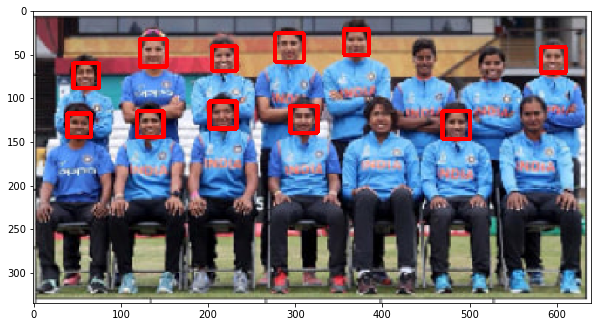

In [498]:
import cv2
import imutils
import matplotlib.pyplot as plt

def lbp_detection_image():

    # load classsifier
    cascade = cv2.CascadeClassifier('models/detection/lbpcascade_frontalface.xml')

    # read image
    image = cv2.imread('images/indian_faces.jpeg')

    # convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resize image to help detection
    # (playing with the image width will yield different performance)
    image = imutils.resize(image, width=640) # better for LBP

    # convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the frame.
    faces = cascade.detectMultiScale(
        gray,               # the input image.
        scaleFactor=1.1,    # specify how much the image size is reduced at each image scale. 
        minNeighbors=5,     # specify how many neighbors each candidate rectangle should have, b
                            # to retain it. A higher number gives lower false positives.
        minSize=(10, 10)    # the minimum rectangle size to be considered a face.
    )

    # draw rectangles around the faces.
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

    # display the image
    plt.figure(figsize = (10, 10))
    _ = plt.imshow(image)

lbp_detection_image()


### HOG
<font style='background-color: yellow'>TODO</font>
- [Histograms of Oriented Gradients (HOG)](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)


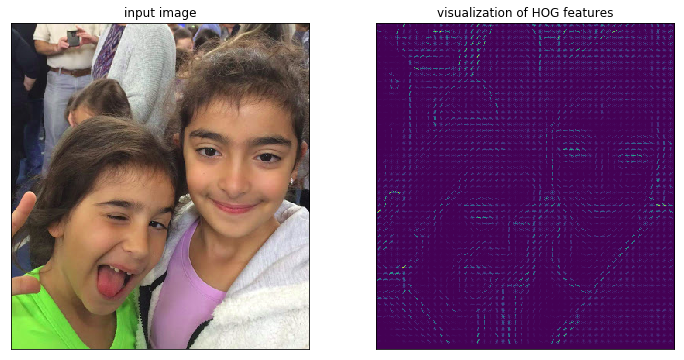

In [557]:
from skimage import data, color, feature
import skimage.data

#image = color.rgb2gray(data.chelsea())
image = cv2.imread('images/Gaya_and_Shani.png')

# convert image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');


### Example: HOG face detection using dlib
The code below will load the same image as before and run dlib HOG face detector.  
We'll the same settings a used in the Haar and LBP face detectors above and see the perforace difference.

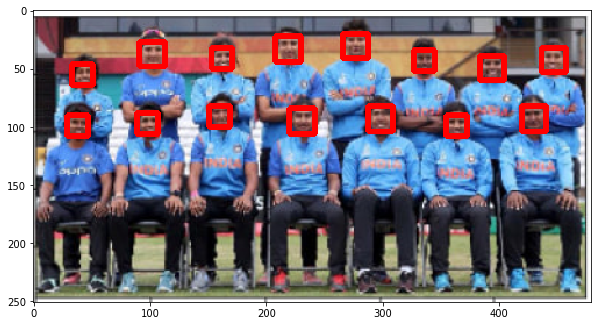

In [546]:
import cv2
import dlib
import imutils
import matplotlib.pyplot as plt

def dlib_hog_detection_image():

    # load model
    detector = dlib.get_frontal_face_detector()
    
    # read image
    image = cv2.imread('images/indian_faces.jpeg')

    # convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resize image to help detection
    image = imutils.resize(image, width=480)

    # no need to convert image to grayscale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the frame.
    faces = detector(image, 2)

    # draw rectangles around the faces.
    for face in faces:
        # convert dlib's rectangle to a bounding box
        (x, y, w, h) = imutils.face_utils.rect_to_bb(face)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

    # display the image
    plt.figure(figsize = (10, 10))
    _ = plt.imshow(image)

dlib_hog_detection_image()


### OpenCV DNN
- OpenCV DNN
<font style='background-color: yellow'>TODO</font>


### Example: OpenCV DNN face detection
The code below will load the same image as before and run OpenCV DNN face detector.  

**Note**: we had to actually change 2 things in order to detect more faces:
```
1. Use of blobFromImage() with the argument: size=(640, 480)
   instead of size=(300, 300) which is what the dnn expects.
2. BGR2RGB conversion: image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
   had to be done after detection!
   
```

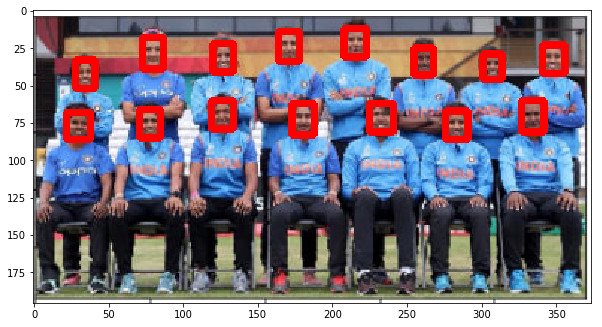

In [543]:
import cv2
import imutils
import matplotlib.pyplot as plt

def opencv_dnn_load_model():
    prototxt_path = 'models/detection/deploy.prototxt.txt'
    model_path = 'models/detection/res10_300x300_ssd_iter_140000.caffemodel'
    model = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
    return model

def opencv_dnn_detection_image(model, image_path, threshold=0.5):

    # read image
    image = cv2.imread(image_path)

    # resize the image to have a maximum width of 400 pixels
    #image = imutils.resize(image, height=640, width=480)
    
    (h, w) = image.shape[:2]

    # grab the image dimensions and convert it to a blob
    blob = cv2.dnn.blobFromImage(image=image, 
                                 scalefactor=1, 
                                 #size=(300, 300), 
                                 size=(640, 480), 
                                 mean=(104.0, 177.0, 123.0), 
                                 swapRB=False, 
                                 crop=False)
    
    # pass the blob through the network to obtain detections
    model.setInput(blob)
    detections = model.forward()
    
    # draw rectangles around the faces.
    #(ih, iw) = image_rgb.shape[:2]
    for i in range(detections.shape[2]):
        
        # filter out weak detections 
        confidence = detections[0, 0, i, 2]
        if confidence < threshold:
            continue # discard detection
        
        # box is (left, top, right, bottom)
        box = (detections[0, 0, i, 3:7] * np.array([w, h, w, h])).astype('int')
        (left, top, right, bottom) = box

        # draw the bounding box
        cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 3)

    # convert BGR2RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # display the image
    plt.figure(figsize = (10, 10))
    _ = plt.imshow(image)
    

# load model
model = opencv_dnn_load_model()

# process image
opencv_dnn_detection_image(model=model, image_path='images/indian_faces.jpeg')

### MTCNN

Face **detection** and **alignment** in unconstrained environment are challenging due to 
- Various poses, illuminations and occlusions. 
- Large search space as faces can be at arbitrary location and of any size.

[Multi-task Cascaded Convolutional Network (MTCNN)](https://arxiv.org/abs/1604.02878v1) achieves impressive performance on these two tasks and is able to outperform many face-detection benchmarks while retaining real-time performance (even on CPU).

The MTCNN algorithm works in three steps and uses one neural network for each (cascaded CNNs, multi-task learning). The first stage is a **Proposal Network (P-Net)** that produces candidate windows quickly through a shallow CNN. The result of this step is a large number of face detections and lots of false detections. The second stage is a **Refinement Network (R-Net)** which refines the windows using a more complex CNN to eliminate most of false detections and aggregate overlapping bounding boxes. Finally, the third stage, **Output Network (O-Net)**, uses a more powerful CNN to refine even more the predictions and outputs the bounding boxes along with facial landmarks.

The **overall pipeline** approach is shown in Fig. 2.1  
<img src='images/mtcnn-pipeline.png' title='MTCNN pipeline' />
<center>
    <font style='text-align: left;'>
        Figure 2.1 - Pipeline overview
    </font>
</center>

**Stage 1**: *Proposal Network (P-Net)*, is used to obtain the candidate windows and their bounding box regression vectors. Then the estimated bounding box regression vectors are used for calibrating the candidates. After that, a non-maximum suppression (NMS) is employed to merge highly overlapped candidates.

**Stage 2**: All candidates are fed to another CNN, called *Refine Network (R-Net)*, further rejects a large number of false candidates, performs calibration with bounding box regression, and NMS candidate merge.

**Stage 3**: Is similar to the second stage, but in this stage aims to describe the face in more details. 
In particular, the network will output five facial landmarks’ positions.

Before the first stage, a given image is resized to different scales in order to build an
**image pyramid** (used for detecting faces of different sizes). Each scaled image version from the pyramid is used as input to the first stage, which contains the P-Net.

<img src='images/mtcnn-image-pyramid.png' title='image-pyramid' width='50%' />
<center>
    <font>
        Figure 2.2 - image pyramid 
        <a href=https://arxiv.org/ftp/arxiv/papers/1604/1604.02878.pdf>source</href>
    </font>
</center>

<img src='images/mtcnn-image-processing.gif' title='MTCNN Image Processing' />
<center>
    <font>
        Figure 2.3 - MTCNN image processing 
    </font>
</center>

**CNN Architectures**:  

The CNN architectures are showed in Fig. 2.4  
It uses three convolutional networks (P-Net, R-Net, and O-Net) where “MP” means max pooling and “Conv” means convolution. The step size in convolution and pooling is 1 and 2, respectively.

<img src='images/mtcnn-srchitectures.png' title='mtcnn Architectures' />
<center>
    <font>
        Figure 2.4 - The architectures of P-Net, R-Net, and O-Net
    </font>
</center>

**Processing**:  

There are three tasks to train the CNN detectors:  
Face/non-face classification, bounding box regression, and facial landmark localization.

**P-Net**

P-Net is a fully convolutional network (FCN) that obtains the candidate windows and their bounding box regression vectors.  The windows are calibrated based on the bouding box regression vector.  Finally, nonmaximum supression is applied to combine windows that have a high overlap.  A fully convolutional network is very similar to a regular CNN, with the difference that it does not contain fully-connected layers at the end.  When we remove the fully-connected layers of a CNN, we also remove the need of a fixed input size.

<img src='images/mtcnn-p-net.png' title='P-Net' width='75%' />
<center>
    <font>
        Figure 2.5 - P-Net
    </font>
</center>

Instead of a label or a feature vector, the output of an FCN is called *heatmap*.  Each point of the heatmap is related to a region in the original input.  Each activation is used as the proposal probability, which means that every point in the original input image has a probability of being a face.  Such probability is then used to locate faces [15].  

P-Net is a fully-convolutional network comprised of three convolutional layers, with 10, 16, and 32 filters. The kernel size for all convolutions is $3 × 3$. A max-pooling of $3 × 3$ is used after the first convolution. P-Net contains three outputs: the face classification (softmax); a bounding box regression; and a facial landmark localization, which are 10 values representing 5 facial landmarks (x, y pairs).  The output of the bounding box regression is used to project the bounding box in the input.  The input is then completed with
zeros until reaching the size of 24 × 24, which is used as input to R-Net. 

**R-Net**

In the second stage, all proposals (candidate windows) are fed to the R-Net. 
This stage extract image patches for each bounding box (from previous stage), resize them (24x24) and forward them through its CNN.  R-Net is responsible for rejecting a large number of false proposals. It is also responsible for performing calibration with bounding box regression. The final process of the second stage is to apply nonmaximum supression. 

<img src='images/mtcnn-r-net.png' title='R-Net' width='75%' />
<center>
    <font>
        Figure 2.6 - R-Net
    </font>
</center>

R-Net is a regular CNN, comprised of three convolutional layers (the first two are followed by max-pooling layers) and a fully connected layer.  R-Net contains more filters and larger volumes when compared
with P-Net. The output of the third convolution is flattened and fully-connected to 128 neurons.  This fully-connected layer has also three outputs, same as in P-Net. The bounding box regression output is projected in the input, completed with zeros and used as input to the O-Net.  

**O-Net**

The third and final stage (O-Net) is very similar to the second one, the only difference is that the CNN is deeper and the number of filters is increased.  This stage extract image patches for each bounding box (from previous stage), resize them (48x48) and forward them through its CNN.  Besides bounding boxes and scores, stage 3 additionally computes 5 face landmarks points for each bounding box.  

<img src='images/mtcnn-o-net.png' title='O-Net' width='75%' />
<center>
    <font>
        Figure 2.7 - O-Net
    </font>
</center>

O-Net is a more complex network, which contains four convolutional layers and more neurons in the fully-connected layer at the end.  The network also contains three outputs, which are the final predictions of MTCNN.  

**Loss functions**  

MTCNN uses a multi-task learning method that optimizes three different loss functions:  
- face classification
- bounding box regression
- facial landmark localization

The first one uses the cross-entropy loss (Equation 2.1).  In this case, there are only two classes (1 and 0) that represent whether the input is a face or not.  We will denote this loss as $L^{face}$.  

<p>
<font size=5>
$$\large{L^{face}} = − \frac{1}{N}\sum_{i=1}^{N}\left[{y_i log(\hat{y}_i) + \left(1 − y_i\right) log\left(1 − \hat{y}_i\right)}\right] \tag{2.1}$$
</font>

The second uses the Euclidean loss, represented by Equation 2.2.  
$\large{L_i^{box}}$ is the loss of input $\large{x_i}$ where $\large{t_i^{box}}$ is the ground truth bounding box and $\large{\hat{t}_i^{box}}$ is the predicted box.  
In this case, each bounding box is represented by four values - (top, left, height, width).  

<p>
<font size=5>
$$\large{L_i^{box}} = \left\vert\left\vert\left( t_i^{box} - \hat{t}_i^{box} \right)\right\vert\right\vert_2^2 \tag{2.2}$$
</font>

Finally, the facial landmark loss is computed similarly to the bounding box regression.  
<p>
<font size=5>
$$\large{L_i^{landmarks}} = \left\vert\left\vert\left( t_i^{landmarks} - \hat{t}_i^{landmarks} \right)\right\vert\right\vert_2^2 \tag{2.2}$$
</font>

**multi-task loss**  

The multi-task loss is given by Equation 2.3 where $N$ is the number of training instances. $j$ represents the task (face, box, landmarks).  $α^j$ represents the task importance.  It is used because each network gives a different importance for the different losses.  

<p>
<font size=5>
$$ \large{min} \sum_{i=1}^{N}\large\sum_{j\in\left\{face, box, landmarks\right\}} α^jβ_i^jL_i^j \tag{2.3}$$
</font>

P-Net and R-Net use $α^{face} = 1, α^{box} = 0.5, α^{landmarks} = 0.5$, as their main goal is to reject proposals without faces.  On the other hand, O-Net uses $α^{face} = 1, α^{box} = 0.5, α^{landmarks} = 1.0$ aiming a better facial landmark localization.  
$β_i^j$ denotes the instance type.  If the given input instance is background (does not contain any face), only $L_i^{face}$ loss is computed, while the other two losses are set to $0$ (setting their $β$ to $0$).  


### Example: MTCNN face detection
The code below will load an image as in previous examples and run the MTCNN face detector.  


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


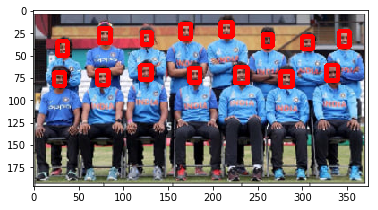

In [8]:
import cv2
import imutils
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt

def mtcnn_detection_image():
    # load model
    detector = MTCNN()

    # read image
    image = cv2.imread('images/indian_faces.jpeg')

    # convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for face in detector.detect_faces(image):
        box = face['box']
        x, y, w, h = box[0], box[1], box[2], box[3]
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

    # display the image
    _ = plt.imshow(image)
    
mtcnn_detection_image()


## Alignment (pose detection)
<font style='background-color: yellow'>TODO</font>

## Feature extraction
<font style='background-color: yellow'>TODO</font>

# Chapter 3
## Face Verification and Identification
Face recognition problems commonly fall into two categories: Face Verification and Face Identification.  
Before moving ahead, let's clarify the difference between verification and identification tasks.

**Verification**: *"is this the claimed person ?"*  

The face verification task is: given an image of a single face, whether it is of a specific known person?  

Example usages: authentication (verifying passport matching at airport, unlocking mobile phone, etc).

Verification can be implemented using a score threshold (an empirical value) such that if the score is below threshold then it is considered positive and vice versa. The score is calculated as the *euclidean distance* between vector representations of the two faces in question. A low score means the detected face is close to the stored historical face of person (and hence verified). Likewise, a high score means both the faces are different.

**Identification**: *"who is this person ?"*  
(aka: face recognition)  
The face identification task is: given an image of a single face, which identity this face belongs to?  

Example usages: office door opening, surveillance, etc.

Identification can be implemented by training a simple multi-class classifier like K-NN or SVM over the vector representations of faces. As we progresses, we shall see how we can train a face classifier.

**Note**:  
For both tasks above, a face detector has to run first in order to detect face bounding rects in the image.

One standard way to generate face vector representation is **one-shot learning**. In the one-shot learning, 
a single face image is passed through the model to produce its embeddings. This embedding can be then used 
as a reference to store in a databse or as the input for verification / identification.


## One shot learning

One of the biggest limitations of **standard classifiers** is that they **require a lots of labelled data**.  
In applications like face recognition, collecting this much data is usually not feasible (think of employees hired or leaving organizations).  

A second limitation of a standard classifier is **we have to re-train for the model to classify a new face**.  
One Shot Learning aims at solving these problems.

**One shot learning** is the technique of learning representations from a single sample.  

In facial recognition for example, you train a One Shot classification model on a dataset that contains many faces with various angles, lighting, etc.  After the model is trained, it is supplied with a **single image of a face** and the network outputs a feature vector for that face. This feature vector is then used to distinguish that face from other faces using euclidean distance.

One Shot learning can be implemented using a **Siamese network**.  
A seamese network does not learn to classify an image directly to any of the output classes.  Rather, it is **learning a similarity function**, which takes two images as input and expresses how similar they are.

## Siamese networks

As the name indicates, a [Siamese network](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) is built from two identical neural networks with the exact same weights, but taking two distinct input images.  The last layers of these two networks are then fed to a **contrastive loss** function.  
This loss will be small when the inputs to the networks are similar and large when they differ.  
This way, optimised Siamese networks can differentiate between their inputs.

<img src='images/seamese-network.png' title='seamese network' />


## Contrastive Loss

Suppose you have as input pairs of images and a label (positive if the two images are the same person or negative otherwise).  *Contrastive Loss* evaluates how well the seames network is distinguishing a given pair of images.  
Thus, this loss should be **low for similar** faces and **large for disimilar** faces.

Lets define $D_w$ (the *euclidean distance* between the outputs of the siamese networks) as:
<p>
<font size=5>
$$\large\mathcal{D_w} = \sqrt{\sum{\{f_w(X_1) - f_w(X_2)\}^2}} \tag{1.1}$$
</font>

- $X_1$ and $X_2$ are the input image pair.
- $f_w(X)$ is the output (embedding) of the network for an image.


The **contrastive loss** is defined as follows:  
<p>
<font size=5>
$$\large\mathcal{L} = \underbrace{(1-Y)\frac{1}{2}(D_w)^2}_\text{same person (y = 0)} + 
    \underbrace{(Y)\frac{1}{2}\{max(0,m-D_w)\}^2}_\text{different person (y = 1)} \tag{1.2}$$
</font>

We would like to minimize the following:
<p>
<font size=5>
$$\large\mathcal{J} = \sum^{N}_{i=1}\mathcal{L} \tag{1.3}$$
</font>

- $Y$ is either 1 or 0. If the inputs are of the same person, then the value of $Y$ is 0, otherwise $Y$ is 1.
- $max()$ is a function denoting the bigger value between 0 and $m - Dw$.
- $m$ is a *margin* value $(m > 0)$.  
  Having a margin indicates that dissimilar pairs beyond this margin will not contribute to the loss.  
  This makes sense, because you only want to optimise the network based on dissimilar pairs which the 
  network thinks are fairly similar.


## Triplet Loss

The *triplet loss* for face recognition has been introduced by the paper [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832) from Google.  

It is similar to contrastive loss, but with triplets (anchor, positive, negative). You don't need labels here.  As an example, the *FaceNet* implementation for face recognition is optimized with triplet loss.

Training will use triplets of images $(A, P, N)$ where:
- $A$ is the **Anchor** image - a picture of a **person**.
- $P$ is a **Positive** image - a picture of the **same person** as the Anchor image.
- $N$ is a **Negative** image - a picture of a **different person** than the Anchor image.

<img src='images/triplet_loss.png' title='triplet loss' width='60%' height='60%' />

The goal of the triplet loss is to make sure that:
- Two examples with the same label have their embeddings close together in the embedding space.
- Two examples with different labels have their embeddings far away.

So, for some distance $d$ on the embedding space, the loss of a triplet $(A, P, N)$ is:

<p>
<font size=5>
$$\mathcal{L} = max(d(A, P) − d(A, N) + margin, 0) \tag{3.1}$$
</font>

<img src='images/triplet-loss-learning.png' title='triplet-loss-learning' />


This one photo could be badly lighted or the pose of the face is really bad.

- ref
  - [Keras_face_identification_realtime (VGGFace, averaging encodings)](https://github.com/Tony607/Keras_face_identification_realtime/blob/master/precompute_features.py)
  - [Building a real time Face Recognition system using pre-trained FaceNet model](https://medium.com/@vinayakvarrier/building-a-real-time-face-recognition-system-using-pre-trained-facenet-model-f1a277a06947)

# Chapter 4

## Facial expression analysis
<font style='background-color: yellow'>TODO</font>
- Age detection
- Gender detection
- Ethnicity detection
- Smile intensity detection
- Facial expression analysis


# Chapter 5

## Playground framework for face recognition.

This cahpter describes a Python playground framework for fast prototyping of face detection and face recognition.  
It integrates multiple face detection and face recognition models from basic models (e.g: Haar Cascades, HOG, LBPH) to more advanced models (e.g: MTCNN, FaceNet).  Each detector model has been made compatible with each embedding model to abstract from the differences.  Models differ in speed, accuracy, resource requirements and 3rd-party dependencies.  This enables to easily experiment with various solutions appropriate for specific use cases.  

The framework is designed to be modular, so that adding new detection or encoding modules is easy. Selection of models is done via the constructors while the exposed functions are detect() or encode() making usage very intuitive.  

This is the [git](https://github.com/yossi-cohen/face-recognition) repository of this framework.

## Preface

A facial recognition system is capable of verifying or identifying a person from a digital image or a video frame from a video source. At a minimum, a facial recognition system should contain the following pipeline:

- **Face Registration** registering faces to a database which includes pre-computing face embeddings and training a classifier on top of the face embeddings of registered individuals.

- **Face Capture** - reading a frame image from a camera source.

- **Face Detection** - detecting faces in a frame image.

- **Face Encoding** - generating a mathematical representation of each face (aka embedding) in the input image/frame.

- **Face Identification** - identifying each face embedding in an image with face embeddings of known people in a database.

More complex systems may include features such as Liveness Detection (for anti-face spoofing attacks), face landmark detection, face alignment, face augmentation (to increase the number of images in a dataset) and face verification.  Such systems may include also: age detection, gender detection, ethnicity detection, emotion detection, smile intensity detection, facial expression analysis etc.  
Some of these may be added to this framework in the future.  

This framework supports several models for each step of the Face Recognition pipeline.  Some models are faster while some are more accurate. You can mix and match the models for your specific use-case, hardware platform and system requirements.  

## Environment

The framework and examples have been tested on Ubuntu 16.04 laptop (Python 3.6.7) using OpenCV 4.1.0, Dlib 19.17.0, Tensorflow 1.13.1 and Keras 2.2.4.

## Usage

### Installation
```
 1. Install Python 3.6 and PIP:
    sudo apt-get update & sudo apt-get install python3.6
    sudo apt install python3-pip
    
 2. Install the required package dependencies using requirements.txt:
    pip install -r requirements.txt
```

### Source folder structure

<img src='images/face-recognition-src-tree.png' />

The ```examples``` folder contains code examples for face detection and face recognition.  These examples may be used directly or through the corresponding cli code. ```face_detection_cli.py``` and ```face_recognition_cli.py``` are the two cli entry points used for detection and recognition. The cli files expose command-line arguments to ease the usage of the examples.

The folders listed below are used by the example code and may be populated by the framework user:  
(any other folders may be used by specifying them in the command line arguments)
```
examples/face_recognition/known_faces
examples/face_recognition/unknown_faces
examples/face_recognition/videos
```

The ```lib``` folder contains the code for abstracting the different models for detection, recognition, landmarks detection and embedding database.

### Pre-requisites

In order to use the framework for detection or face recognition, the ```known_faces``` and ```unknown_faces``` folders should be populated with images for learning and testing respectively.  

The ```known_faces``` folder may contain images or sub-folders.  Images not under a sub-folder should have name corresponding to the name of the person to identify in the face recognition process. Multiple images for a single person are also supported and may yield better recognition results. Multiple images of the same person should be place under a folder named with the person_name.  The ```videos``` folder may contain video file for testing the face recognition after it is train on the ```known_faces``` folder.

**Note**: When adding faces to the face-database, each image should contain a single face.

### Examples

```
face detection method: 'haar', 'lbp', 'hog', 'dnn', 'mtcnn'
```

From within the ```src``` directory call either one of ```face_detection_cli.py``` or ```face_recognition_cli.py``` as the section below:

#### Face detection command-line args

```
-m, --method:                 face detection method: (default: hog)
                              ('haar', 'lbp', 'hog', 'dnn', 'mtcnn')
-t, --threshold:              confidence threshold (default: 0.5)
-n, --detect_every_n_frames:  detect faces every N frames 
                              for speeding up processing.
-v, --video_path:             path to video file
-i, --image_path:             path to input image path
-f, --full:                   full-screen
```

#### Face recognition command-line args

All arguments same as for detection and in addition:  

```
-s, --scan:                   add images to face-db 
                              (scans the 'known_faces' folder)
-a, --add:                    add a single face to face-db
                              (may be used with -i to specify image path)
-r, --recognize:              recognize faces mode (image/video/livecam)
-k, --known_faces:            path to known faces folder 
                              (default: known_faces)
-l, --live:                   input video from webcam
-e, --encodings:              returns encodings for a given image path
```

### Face Detection in images

Example usage - detecting in a single image file: 
```
python face_detection_cli.py -i [path-to-image-file] [-m mtcnn] [-t 0.85]

```

Example usage - detecting in all image files under a folder:
```
python face_detection_cli.py -i [path-to-images-folder]
```

### Face Detection in a video file

Example usage: 
```
python face_detection_cli.py -v [path-to-video-file]
```

### Face Detection in realtime (webcam)
Example usage: 
```
python face_detection_cli.py -l
```

### Scan all faces under a folder to the known faces database
Example usage: 
```
python face_recognition_cli.py -s -i [path-to-known-faces-folder (default: known_faces)]
```

### Add a face to the known faces database
Example usage: 
```
python face_recognition_cli.py -a -i [path-to-image-file]
```

### Recognize faces in an image
Example usage: 
```
python face_recognition_cli.py -i [path-to-images-folder]
```

### Recognize faces in a video file
Example usage: 
```
python face_recognition_cli.py -v [path-to-video-file]
```

### Recognize faces in realtime (webcam)
Example usage: 
```
python face_recognition_cli.py -l
```


# Chapter 6
## Concluding remarks and directions for future work.
<font style='background-color: yellow'>TODO</font>


## References

[[1]](https://arxiv.org/abs/1612.04402) P. Viola and M. Jones. Rapid object detection using a boosted cascade of simple features. 2001.

[[2]](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) Navneet Dalal and Bill Triggs. Histograms of Oriented Gradients for Human Detection. 2005.

[[3]](http://image.diku.dk/imagecanon/material/cortes_vapnik95.pdf) Cortes, C.; Vapnik, V. “Support-vector networks”, Machine Learning, vol. 20–3, 1995, pp.
273–297.

[[4]](https://arxiv.org/abs/1612.04402) Peiyun Hu and Deva Ramanan. Finding Tiny Faces. 2017.  
[[4.1]](https://github.com/alexattia/ExtendedTinyFaces) ExtendedTinyFaces

[[5]](https://pdfs.semanticscholar.org/d78b/6a5b0dcaa81b1faea5fb0000045a62513567.pdf) Vahid Kazemi and Josephine Sullivan. One Millisecond Face Alignment with an Ensemble of Regression Trees

[[6]](https://arxiv.org/abs/1503.03832) Florian Schroff, Dmitry Kalenichenko and James Philbin. FaceNet: A Unified Embedding for Face Recognition and Clustering. 2015

[[7]](https://arxiv.org/abs/1604.02878) Kaipeng Zhang, Zhanpeng Zhang, Zhifeng Li, Yu Qiao. Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks

[[8]](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) Taigman, Y.; Yang, M.; Ranzato, M.; Wolf, L. “Deepface: Closing the gap to human-level
performance in face verification”. In: Conference on Computer Vision and Pattern Recognition,
CVPR 2014, 2014, pp. 1701–1708.

[[9]](https://arxiv.org/pdf/1505.02108.pdf) MegaFace: A Million Faces for Recognition at Scale

[[10]](http://www.robots.ox.ac.uk/~vgg/publications/2018/Cao18/cao18.pdf) VGGFace2: A dataset for recognising faces across pose and age

[[11]](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Siamese Neural Networks for One-shot Image Recognition

[[12]](https://arxiv.org/pdf/1604.02878.pdf) Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks

[[13]](http://vis-www.cs.umass.edu/lfw/lfw.pdf) Huang, G. B.; Ramesh, M.; Berg, T.; Learned-Miller, E. “Labeled faces in the wild: A
database for studying face recognition in unconstrained environments”, Technical Report 07-
49, University of Massachusetts, Amherst, 2007.

[[14]](http://vis-www.cs.umass.edu/fddb/) Jain, V.; Learned-Miller, E. “Fddb: A benchmark for face detection in unconstrained settings”,
Technical Report UM-CS-2010-009, University of Massachusetts, Amherst, 2010.

[[15]](https://arxiv.org/pdf/1609.03536.pdf) Yang, Z.; Nevatia, R. “A multi-scale cascade fully convolutional network face detector”, CoRR,
vol. abs/1609.03536, 2016.

## More references

  - [appliedmachinelearning.blog](https://appliedmachinelearning.blog/2018/10/30/yet-another-face-recognition-demonstration-on-images-videos-using-python-and-tensorflow/)
  
  - [Yet Another Face Recognition Demonstration on Images/Videos : Using Python and Tensorflow](https://appliedmachinelearning.blog/2018/10/30/yet-another-face-recognition-demonstration-on-images-videos-using-python-and-tensorflow/)

### detection
- [Finding Tiny Faces](https://github.com/peiyunh/tiny)

#### Haar
- [Haar Face Detection with OpenCV-Python](https://www.datacamp.com/community/tutorials/face-detection-python-opencv)

#### LBPH

- [Face Recognition: Understanding LBPH Algorithm](https://towardsdatascience.com/face-recognition-how-lbph-works-90ec258c3d6b)

#### Verification
one-to-one matching

#### Identification
one-to-many matching

FACIAL IMAGE CLASSIFICATION AND SEARCHING
 - [svm](https://www.google.co.il/search?newwindow=1&biw=1301&bih=640&ei=JPPoXMmgB4bykwWF5Ym4BQ&q=face+identification+svm&oq=face+identification+svm&gs_l=psy-ab.3..35i39.33562.33735..33953...0.0..0.131.252.0j2......0....1..gws-wiz.......0i71.Mg82nQN2u70)

[MegaFace: A Million Faces for Recognition at Scale](https://arxiv.org/pdf/1505.02108.pdf)

Theory
- one shot learning
- Siamese network
- triple loss

[real-time-face-recognition-system-using-pre-trained-facenet](https://medium.com/@vinayakvarrier/building-a-real-time-face-recognition-system-using-pre-trained-facenet-model-f1a277a06947)

[face_recognition_knn](https://github.com/ageitgey/face_recognition/blob/master/examples/face_recognition_knn.py)  
When should I use this ?
This is useful when you wish to recognize a large set of known people.  
The knn classifier is first trained on a set of labeled (known) faces and can then predict the person
in an unknown image by finding the k most similar faces (images with closet face-features under eucledian distance)
in its training set, and performing a majority vote (possibly weighted) on their label.

Haar
https://www.datacamp.com/community/tutorials/face-detection-python-opencv

### triplet loss
- [Triplet Loss](https://omoindrot.github.io/triplet-loss)
- [deeplearning.ai](https://github.com/JudasDie/deeplearning.ai/blob/master/Convolutional%20Neural%20Networks/week4/FaceNet/Face%2BRecognition%2Bfor%2Bthe%2BHappy%2BHouse%2B-%2Bv2.ipynb)
- [Lossless Triplet loss - A more efficient loss function for Siamese NN](https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24)

### One Shot Learning
- [One Shot Learning with Siamese Networks using Keras](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d)
- [Hackernoon - One Shot Learning with Siamese Networks in PyTorch](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e)
- [Building a real time Face Recognition system using pre-trained FaceNet model](https://medium.com/@vinayakvarrier/building-a-real-time-face-recognition-system-using-pre-trained-facenet-model-f1a277a06947)
  - [A light weight face recognition implementation using a pre-trained facenet model](https://github.com/vinayakkailas/Face_Recognition)

### Training
- [Deep face recognition with Keras, Dlib and OpenCV](http://krasserm.github.io/2018/02/07/deep-face-recognition/)

### Misc
- [Yet Another Face Recognition Demonstration on Images/Videos : Using Python and Tensorflow](https://appliedmachinelearning.blog/2018/10/30/yet-another-face-recognition-demonstration-on-images-videos-using-python-and-tensorflow/)

### face clustering
- https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/

### liveness detection
- https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3
